# Practical 9
## Perform text classification.

In [30]:
from nlp_lib import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import joblib
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

### Loading Dataset and Analyzing it

In [2]:
df=pd.read_csv("bbc_text.csv")

In [5]:
df.columns

Index(['category', 'text'], dtype='object')

In [6]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [7]:
df.category.value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [8]:
df_min=df.category.value_counts().min()

In [9]:
df_min

386

### Doing UnderSampling for getting Balanced Dataset

In [11]:
min_samples = df_min

undersampled_dfs = []

for category in df['category'].unique():
    df_category = df[df['category'] == category]
    
    if len(df_category) < min_samples:
        df_category_undersampled = resample(df_category, 
                                            replace=True, 
                                            n_samples=min_samples, 
                                            random_state=42)
    else:
        df_category_undersampled = resample(df_category, 
                                            replace=False, 
                                            n_samples=min_samples, 
                                            random_state=42)
    
    undersampled_dfs.append(df_category_undersampled)

df_undersampled = pd.concat(undersampled_dfs)

df_undersampled = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_undersampled['category'].value_counts())

category
sport            386
politics         386
tech             386
business         386
entertainment    386
Name: count, dtype: int64


In [12]:
df=df_undersampled

In [13]:
df.tail()

,category,text
1925,sport,saint-andre anger at absent stars sale sharks ...
1926,entertainment,manics in charge of bbc 6 music the manic stre...
1927,sport,adriano s chelsea link rejected adriano s agen...
1928,entertainment,smith loses us box office crown new comedy dia...
1929,sport,collins to compete in birmingham world and com...


### Mapping Categories to Numerical Values

In [14]:
df['target'] = df.category.map({'sport': 0,'politics':1,'tech':2,'business':3,'entertainment':4})

In [16]:
df.sample(5)

,category,text,target
1639,entertainment,spike lee backs student directors film-maker s...,4
552,sport,tottenham bid &#163;8m for forest duo nottingh...,0
615,politics,tories unveil quango blitz plans plans to abol...,1
1879,politics,errors doomed first dome sale the initial att...,1
868,entertainment,berlin honours s korean director south korean ...,4


### Doing Text Cleaning and Pre-Processing 

In [18]:
string.digits

'0123456789'

In [21]:
def remove_digits(text):
  if pd.isnull(text):  
        return np.nan
  text = text.translate(str.maketrans('', '', string.digits))
  return text.strip()

In [22]:
df['text']=df['text'].str.lower()
df['text']=df['text'].apply(remove_html_tags)
df['text']=df['text'].apply(remove_url)
df['text']=df['text'].apply(removes_specials)
df['text']=df['text'].apply(removes_non_printables)
df['text']=df['text'].apply(remove_punctuations)
df['text']=df['text'].apply(remove_digits)

In [23]:
df['text']=df['text'].apply(preprocesswithlema)

In [24]:
df.sample(5)

,category,text,target
4,tech,consumer snub portable video consumer want...,2
512,sport,uefa approve fake grass uefa say allow europea...,0
1526,politics,cabinet anger brown cash raid minister unhappy...,1
1776,politics,uk need true immigration datum home office...,1
1781,sport,benitez joy red control liverpool boss rafael ...,0


### Dividing Data into Training(80%) And Testing(20%) Sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

### Training The Model and Printing the Result

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        77
           1       0.96      0.99      0.97        78
           2       0.96      0.99      0.97        78
           3       0.99      0.95      0.97        77
           4       0.99      0.97      0.98        76

    accuracy                           0.98       386
   macro avg       0.98      0.98      0.98       386
weighted avg       0.98      0.98      0.98       386

1118    u play grammy awards irish rock band u play li...
1654    tv s future phone line internet tv talk start ...
1865    bat spit drug firm go market german firm main ...
941     trouble marsh sec scrutiny stock market regula...
331     window worm travel tetris user warn windows vi...
Name: text, dtype: object 1118    4
1654    2
1865    3
941     3
331     2
Name: target, dtype: int64 [4 2 3 3 2]


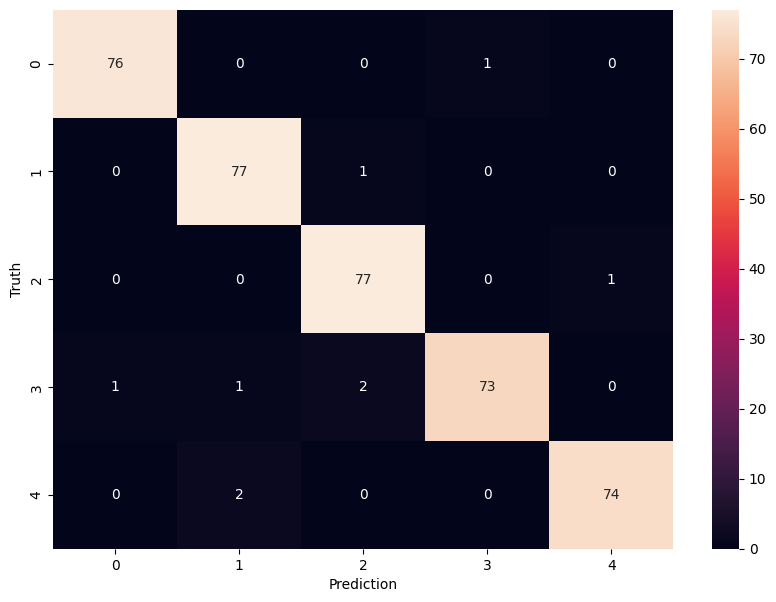

In [31]:
pipeline = Pipeline([
        ('TFIDFvectorizer', TfidfVectorizer(ngram_range=(1, 3))),
        ('LinearSVC', LinearSVC())
    ])
# Train the model
pipeline.fit(X_train, y_train)
# Make predictions
y_pred = pipeline.predict(X_test)
#Print Classification Report
print(classification_report(y_test, y_pred,zero_division=0))
print(X_test[:5],y_test[:5],y_pred[:5])
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True,fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

### Training Model on Whole Dataset and Saving it

In [32]:
pipeline = Pipeline([
        ('TFIDFvectorizer', TfidfVectorizer(ngram_range=(1, 3))),
        ('LinearSVC', LinearSVC())
    ])
# Train the model on whole dataset
pipeline.fit(df['text'], df['target'])
joblib.dump(pipeline, "text_classification.joblib")

['text_classification.joblib']

### Doing Prediction Using Saved Model

In [40]:
# Load the saved model from the file
loaded_pipeline = joblib.load("text_classification.joblib")

# Use the loaded model to make predictions on new data
new_data = ["this competition was great", "this is a comedy show"]
a = preprocesswithlema(new_data[0])
b = preprocesswithlema(new_data[1])
new_data=[a,b]
predictions = loaded_pipeline.predict(new_data)
# Map predictions to category names
dictionary = {0: 'sport', 1: 'politics', 2: 'tech', 3: 'business', 4: 'entertainment'}
# Print predictions
for i, prediction in enumerate(predictions):
    print(f"Prediction for '{new_data[i]}': {dictionary[prediction]}")

Prediction for 'competition great': sport
Prediction for 'comedy': entertainment
